# Imports

In [ ]:
test_path = "/content/drive/MyDrive/Colab Notebooks/nlp-project-3-dataset/test.csv"
train_path = "/content/drive/MyDrive/Colab Notebooks/nlp-project-3-dataset/train.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GlobalMaxPool1D
from tensorflow.python.keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix


import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import time

from gensim.models.word2vec import Word2Vec
from glob import glob

# Reading data and Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [ ]:
trainx = train_df["text"]
testx = test_df["text"]

trainy_raw = train_df["label"]
trainy_integer = []
for i in range(len(trainy_raw)):
  if trainy_raw[i] == 'spor':
    trainy_integer.append(0)
  elif trainy_raw[i] == 'yazarlar':
    trainy_integer.append(1)
  elif trainy_raw[i] == 'video':
    trainy_integer.append(2)
  elif trainy_raw[i] == 'dunya':
    trainy_integer.append(3)
  elif trainy_raw[i] == 'turkiye':
    trainy_integer.append(4)
  
testy_raw = test_df["label"]
testy_integer = []
for i in range(len(testy_raw)):
  if testy_raw[i] == 'spor':
    testy_integer.append(0)
  elif testy_raw[i] == 'yazarlar':
    testy_integer.append(1)
  elif testy_raw[i] == 'video':
    testy_integer.append(2)
  elif testy_raw[i] == 'dunya':
    testy_integer.append(3)
  elif testy_raw[i] == 'turkiye':
    testy_integer.append(4)


testy_integer = np.array(testy_integer)
trainy_integer = np.array(trainy_integer)

trainy= np.zeros((trainy_integer.size, trainy_integer.max()+1))
trainy[np.arange(trainy_integer.size),trainy_integer] = 1

testy= np.zeros((testy_integer.size, testy_integer.max()+1))
testy[np.arange(testy_integer.size),testy_integer] = 1

trainx = np.array(trainx)
testx = np.array(testx)

In [ ]:
#Preprocessing
import re

def splitIntoStem(message):
  return [removeNumeric(removeBackSlash(stemWord(word))) for word in message.split()]

def stemWord(value):
    return value.lower()

def removeBackSlash(value):
  return re.sub(r'[\\]','',value)

#Remove numeric character
def removeNumeric(value):
    blist2 = [item for item in value if not item.isdigit()]
    blist3 = "".join(blist2)
    return blist3


In [ ]:
print("BEFORE: Key:",testx[0],"- Value:",testy_raw[0])

for i in range(len(testx)):
  testx[i] = " ".join(splitIntoStem(testx[i])).split()

print("AFTER: Key:",testx[0],"- Value:",testy[0])

for i in range(len(trainx)):
  trainx[i] = " ".join(splitIntoStem(trainx[i])).split()

BEFORE: Key: "Filmimde oynadı ama 32 yıldır görmüyordum abimi" diyen ve heyecanlanarak gözyaşlarına boğulan Cem Yılmaz'ı izleyenler kahkahalara boğuldu. - Value: video
AFTER: Key: ['"filmimde', 'oynadı', 'ama', 'yıldır', 'görmüyordum', 'abimi"', 'diyen', 've', 'heyecanlanarak', 'gözyaşlarına', 'boğulan', 'cem', "yılmaz'ı", 'izleyenler', 'kahkahalara', 'boğuldu.'] - Value: [0. 0. 1. 0. 0.]


In [ ]:
#Remove stopwords
from nltk.corpus import stopwords

def removeStopWords(news_list):
    
    filtered_stopwords = []
    filtered_stopwords_list = []
    
    stop_words = stopwords.words('turkish')

    stop_words.append("bir")
    stop_words.append("iki")
    stop_words.append("üç")
    stop_words.append("dört")
    stop_words.append("beş")
    stop_words.append("altı")
    stop_words.append("yedi")
    stop_words.append("sekiz")
    stop_words.append("dokuz")
    stop_words.append("on")
    
    
    for i in news_list:
        filtered_sentence = [w for w in i if not w in stop_words]
        filtered_stopwords_list.append(filtered_sentence)                         #return list value
        filtered_stopwords.append(" ".join(filtered_sentence))                    #return string value
    
    return filtered_stopwords,filtered_stopwords_list                                      


testx,testx_filtered_stopwords_list = removeStopWords(testx)
trainx,trainx_filtered_stopwords_list = removeStopWords(trainx)

# Tokenizing and Padding Words

In [ ]:
import pandas as pd 

tokenizer = Tokenizer(oov_token='OOV', filters='"#$%&()*+,-/:;<=>@[\]^_`{|}~ ')             #Tokenizer(num_words=5000) => 5000 words of the highest frequency
tokenizer.fit_on_texts(trainx)
tokenizer 

In [ ]:
num_words = len(list(tokenizer.word_index))
num_words

226460

In [ ]:
list(tokenizer.word_index)[0:5]

['OOV', 'olarak', '.', 'olan', 'sonra']

In [ ]:
trainx_tokens = tokenizer.texts_to_sequences(trainx)
testx_tokens = tokenizer.texts_to_sequences(testx)

In [ ]:
len(trainx_tokens[0])

86

In [ ]:
len(trainx[0].split())

86

In [ ]:
num_tokens = [len(tokens) for tokens in trainx_tokens]
num_tokens = np.array(num_tokens)

In [ ]:
num_tokens[0]

86

In [ ]:
len(trainx[np.argmax(num_tokens)].split())

6448

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

634

In [ ]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.97475

In [ ]:
trainx_pad = pad_sequences(trainx_tokens, maxlen=max_tokens,padding='post')
testx_pad = pad_sequences(testx_tokens, maxlen=max_tokens,padding='post')

In [ ]:
print("trainx_tokens :",trainx_tokens[0])
print("trainx_pad :",trainx_pad[0])

trainx_tokens : [1295, 81, 105, 606, 4964, 3498, 11, 5752, 356, 40178, 458, 91, 415, 1270, 9790, 485, 13886, 8519, 18798, 4, 415, 1270, 376, 1914, 5387, 5752, 3743, 13, 199, 4964, 3498, 18799, 893, 1295, 81, 105, 606, 4964, 3498, 716, 658, 100, 5621, 1720, 2889, 1602, 9106, 352, 415, 1270, 4964, 20264, 495, 446, 583, 96, 15457, 3803, 63799, 16442, 95160, 1721, 26667, 811, 301, 485, 802, 34262, 105, 606, 4, 4964, 3498, 1915, 4654, 862, 1416, 1055, 17511, 4850, 390, 583, 96, 17512, 49159, 63800]
trainx_pad : [ 1295    81   105   606  4964  3498    11  5752   356 40178   458    91
   415  1270  9790   485 13886  8519 18798     4   415  1270   376  1914
  5387  5752  3743    13   199  4964  3498 18799   893  1295    81   105
   606  4964  3498   716   658   100  5621  1720  2889  1602  9106   352
   415  1270  4964 20264   495   446   583    96 15457  3803 63799 16442
 95160  1721 26667   811   301   485   802 34262   105   606     4  4964
  3498  1915  4654   862  1416  1055 17511  4850  

# CNN with Random Embeddings

In [ ]:
weight_decay = 1e-4
# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(num_words+1, 100, input_length=max_tokens))
model.add(Conv1D(16, 4, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(200, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.75))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 634, 100)          22646100  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 634, 16)           6416      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 317, 16)           0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 158, 16)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2528)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               505800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)              

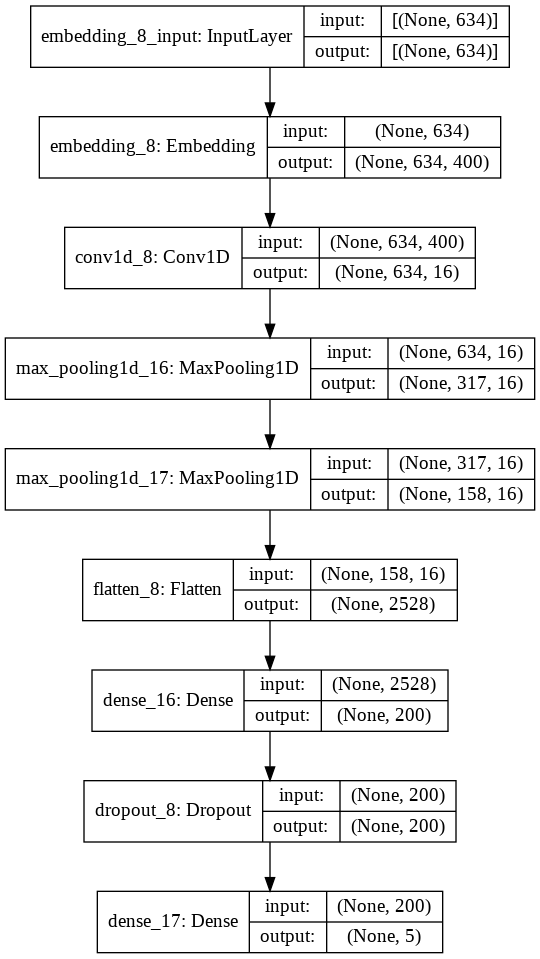

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callbacks_list = [early_stopping]
from tensorflow import keras
keras.utils.plot_model(model, "random_embeddings.png", show_shapes=True)

In [ ]:
from sklearn.model_selection import train_test_split
trainx_pad, valx_pad, trainy, valy = train_test_split(trainx_pad, trainy, test_size=0.1, random_state=42)

# Fitting the data onto model
model.fit(trainx_pad, trainy, validation_data=(valx_pad, valy), epochs=6, batch_size=16, verbose=1,callbacks=callbacks_list)
# Getting score metrics from our model
scores = model.evaluate(testx_pad, testy, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/6
240/240 [==============================] - 52s 214ms/step - loss: 1.4576 - accuracy: 0.3695 - val_loss: 1.1028 - val_accuracy: 0.5200
Epoch 2/6
240/240 [==============================] - 52s 215ms/step - loss: 0.9433 - accuracy: 0.6111 - val_loss: 0.6995 - val_accuracy: 0.7129
Epoch 3/6
240/240 [==============================] - 51s 214ms/step - loss: 0.3915 - accuracy: 0.8717 - val_loss: 0.6382 - val_accuracy: 0.8376
Epoch 4/6
240/240 [==============================] - 51s 214ms/step - loss: 0.1820 - accuracy: 0.9517 - val_loss: 0.7709 - val_accuracy: 0.7953
Epoch 5/6
240/240 [==============================] - 51s 214ms/step - loss: 0.1067 - accuracy: 0.9768 - val_loss: 0.8171 - val_accuracy: 0.7976
Epoch 00005: early stopping
Accuracy: 82.15%


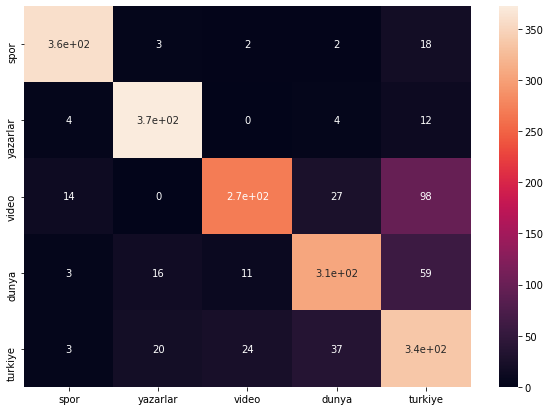

In [ ]:
import sklearn.metrics as metrics,classification_report

# rounded_predictions = model.predict_classes(test_imag)
y_pred_ohe = model.predict(testx_pad)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_pred_labels[0:10]

# y_pred= np.zeros((y_pred_labels.size, y_pred_labels.max()+1))
# y_pred[np.arange(y_pred_labels.size),y_pred_labels] = 1

confusion_matrix = metrics.confusion_matrix(y_true=testy_integer, y_pred=y_pred_labels)  # shape=(12, 12)

import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ["spor","yazarlar","video","dunya","turkiye"]],
                  columns = [i for i in ["spor","yazarlar","video","dunya","turkiye"]])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)


In [ ]:
target_names = ["spor","yazarlar","video","dunya","turkiye"]
print(classification_report(y_pred_labels,testy_integer, target_names=target_names))

              precision    recall  f1-score   support

        spor       0.93      0.94      0.94       383
    yazarlar       0.95      0.91      0.93       411
       video       0.66      0.88      0.75       306
       dunya       0.77      0.81      0.79       376
     turkiye       0.80      0.64      0.71       524

    accuracy                           0.82      2000
   macro avg       0.82      0.84      0.82      2000
weighted avg       0.83      0.82      0.82      2000



# CNN with akoksal Embeddings

In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/nlp-project-3-dataset/trmodel", binary=True)

embedding_matrix = np.zeros((num_words+1, 400))
for word, i in tokenizer.word_index.items():
    if i>=num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),400)

2021-01-05 01:12:52,202 : INFO : loading projection weights from /content/drive/MyDrive/Colab Notebooks/nlp-project-3-dataset/trmodel
2021-01-05 01:13:01,287 : INFO : loaded (412457, 400) matrix from /content/drive/MyDrive/Colab Notebooks/nlp-project-3-dataset/trmodel


In [ ]:
embedding_matrix.shape

(226461, 400)

In [ ]:
from keras.initializers import Constant
weight_decay = 1e-4
# # Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(num_words+1,
                            400,
                            weights=[embedding_matrix],
                            # embeddings_initializer = Constant(embedding_matrix),
                            input_length=max_tokens,
                            trainable=False))
model.add(Conv1D(16, 4, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(200, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.75))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 634, 400)          90584400  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 634, 16)           25616     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 317, 16)           0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 158, 16)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2528)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               505800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)              

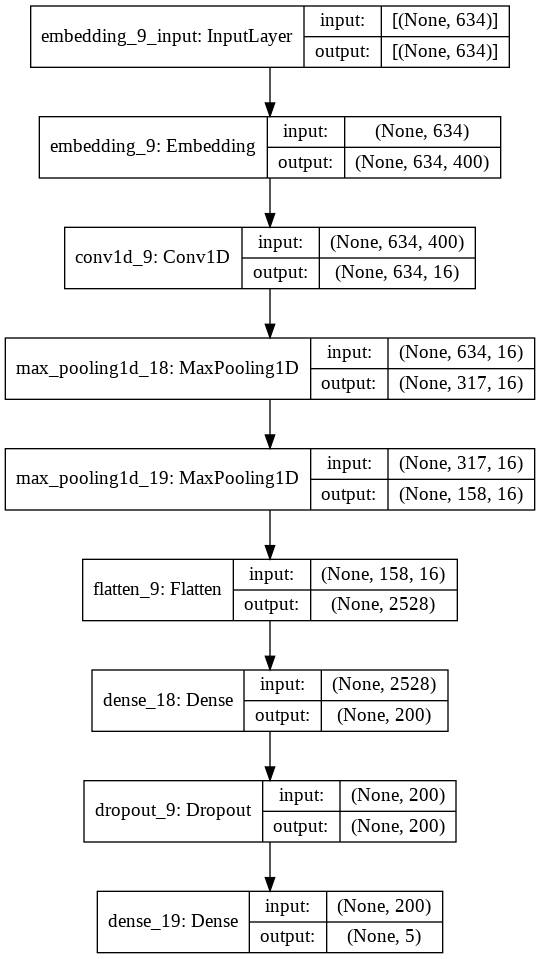

In [ ]:
keras.utils.plot_model(model, "github_embeddings.png", show_shapes=True)

In [ ]:
# Fitting the data onto model
model.fit(trainx_pad, trainy, validation_data=(valx_pad, valy), epochs=30, batch_size=32, verbose=1,callbacks=callbacks_list)
# Getting score metrics from our model
scores = model.evaluate(testx_pad, testy, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/30
120/120 [==============================] - 2s 16ms/step - loss: 1.6780 - accuracy: 0.4246 - val_loss: 0.7937 - val_accuracy: 0.7294
Epoch 2/30
120/120 [==============================] - 2s 13ms/step - loss: 0.8123 - accuracy: 0.7174 - val_loss: 0.6487 - val_accuracy: 0.7929
Epoch 3/30
120/120 [==============================] - 2s 13ms/step - loss: 0.6125 - accuracy: 0.7982 - val_loss: 0.5391 - val_accuracy: 0.8212
Epoch 4/30
120/120 [==============================] - 2s 14ms/step - loss: 0.4580 - accuracy: 0.8454 - val_loss: 0.5631 - val_accuracy: 0.8353
Epoch 5/30
120/120 [==============================] - 2s 13ms/step - loss: 0.3876 - accuracy: 0.8750 - val_loss: 0.5404 - val_accuracy: 0.8282
Epoch 00005: early stopping
Accuracy: 80.50%


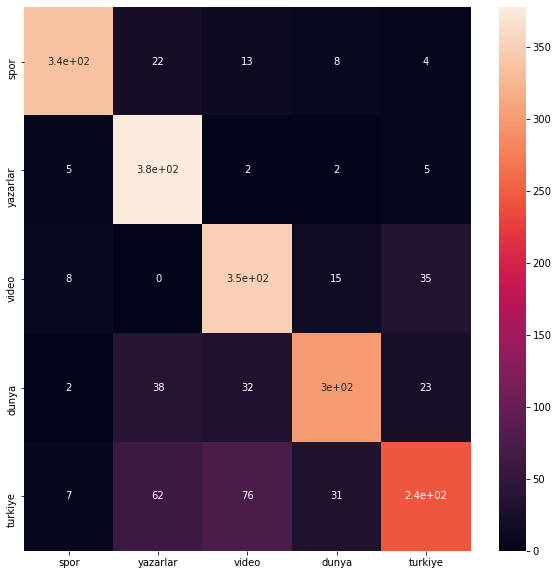

In [ ]:

# rounded_predictions = model.predict_classes(test_imag)
y_pred_ohe = model.predict(testx_pad)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_pred_labels[0:10]

# y_pred= np.zeros((y_pred_labels.size, y_pred_labels.max()+1))
# y_pred[np.arange(y_pred_labels.size),y_pred_labels] = 1

confusion_matrix = metrics.confusion_matrix(y_true=testy_integer, y_pred=y_pred_labels)  # shape=(12, 12)

import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ["spor","yazarlar","video","dunya","turkiye"]],
                  columns = [i for i in ["spor","yazarlar","video","dunya","turkiye"]])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)


In [ ]:
target_names = ["spor","yazarlar","video","dunya","turkiye"]
print(classification_report(y_pred_labels,testy_integer, target_names=target_names))

              precision    recall  f1-score   support

        spor       0.88      0.94      0.91       359
    yazarlar       0.96      0.76      0.85       500
       video       0.86      0.74      0.79       473
       dunya       0.76      0.84      0.80       356
     turkiye       0.58      0.79      0.67       312

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.80      2000
weighted avg       0.83      0.81      0.81      2000



# CNN with homework2 Embeddings

In [ ]:
word2vec_hw2 = {}
with open("/content/drive/MyDrive/Colab Notebooks/10kwe_32", encoding='UTF-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec_hw2[word] = vec

embedding_matrix_hw2 = np.zeros((num_words+1, 32))
for word, i in tokenizer.word_index.items():
    if i>=num_words:
        continue
    try:
        embedding_vector = word2vec_hw2[word]
        embedding_matrix_hw2[i] = embedding_vector
    except KeyError:
        embedding_matrix_hw2[i]=np.random.normal(0,np.sqrt(0.25),32)

In [ ]:
from keras.initializers import Constant
weight_decay = 1e-4
# # Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(num_words + 1,
                            32,
                            weights=[embedding_matrix_hw2],
                            # embeddings_initializer = Constant(embedding_matrix),
                            input_length=max_tokens,
                            trainable=True))
model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(200, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.75))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 634, 32)           7246752   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 634, 32)           8224      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 317, 32)           0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 158, 32)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5056)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               1011400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)             

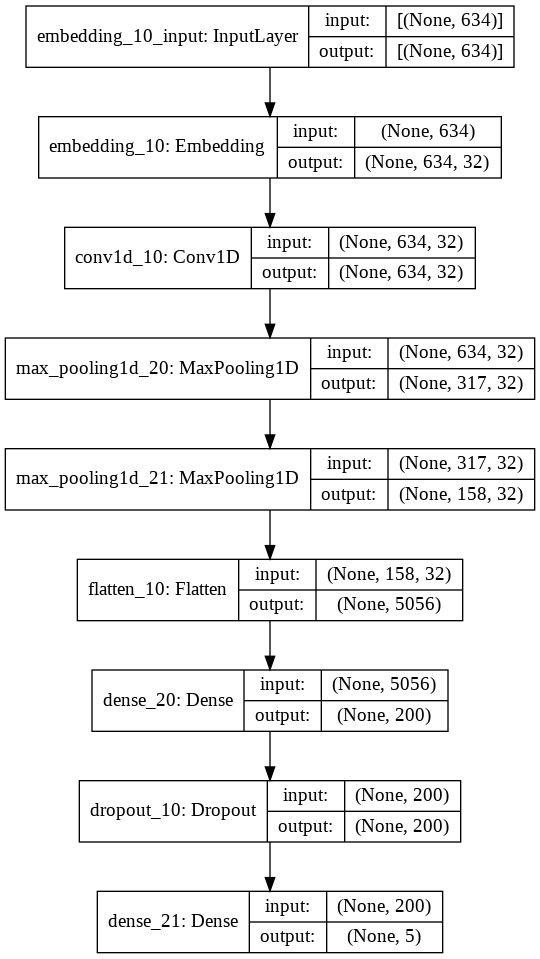

In [ ]:
keras.utils.plot_model(model, "hw2_embeddings.png", show_shapes=True)

In [ ]:
# Fitting the data onto model
model.fit(trainx_pad, trainy, validation_data=(valx_pad, valy), epochs=30, batch_size=32, verbose=1,callbacks=callbacks_list)
# Getting score metrics from our model
scores = model.evaluate(testx_pad, testy, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/30
120/120 [==============================] - 10s 75ms/step - loss: 1.3548 - accuracy: 0.5165 - val_loss: 0.6046 - val_accuracy: 0.7953
Epoch 2/30
120/120 [==============================] - 9s 74ms/step - loss: 0.5935 - accuracy: 0.8059 - val_loss: 0.5472 - val_accuracy: 0.8212
Epoch 3/30
120/120 [==============================] - 9s 74ms/step - loss: 0.4021 - accuracy: 0.8781 - val_loss: 0.4951 - val_accuracy: 0.8306
Epoch 4/30
120/120 [==============================] - 9s 74ms/step - loss: 0.3025 - accuracy: 0.9132 - val_loss: 0.4998 - val_accuracy: 0.8329
Epoch 5/30
120/120 [==============================] - 9s 74ms/step - loss: 0.2250 - accuracy: 0.9316 - val_loss: 0.5989 - val_accuracy: 0.8376
Epoch 00005: early stopping
Accuracy: 83.45%


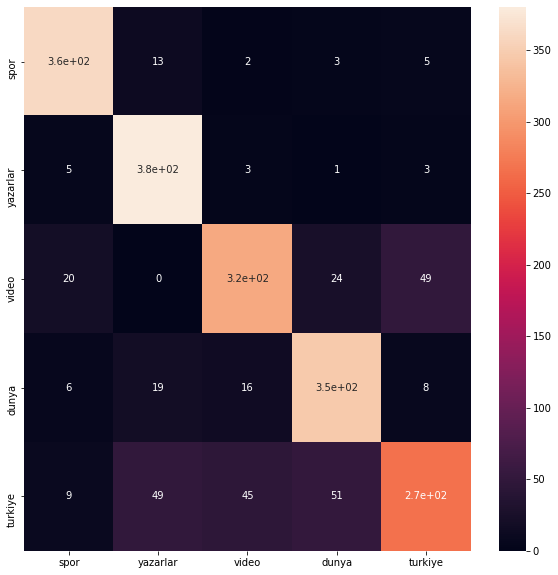

In [ ]:

# rounded_predictions = model.predict_classes(test_imag)
y_pred_ohe = model.predict(testx_pad)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_pred_labels[0:10]

# y_pred= np.zeros((y_pred_labels.size, y_pred_labels.max()+1))
# y_pred[np.arange(y_pred_labels.size),y_pred_labels] = 1

confusion_matrix = metrics.confusion_matrix(y_true=testy_integer, y_pred=y_pred_labels)  # shape=(12, 12)

import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ["spor","yazarlar","video","dunya","turkiye"]],
                  columns = [i for i in ["spor","yazarlar","video","dunya","turkiye"]])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)


In [ ]:
target_names = ["spor","yazarlar","video","dunya","turkiye"]
print(classification_report(y_pred_labels,testy_integer, target_names=target_names))

              precision    recall  f1-score   support

        spor       0.94      0.90      0.92       401
    yazarlar       0.97      0.82      0.89       461
       video       0.77      0.83      0.80       381
       dunya       0.88      0.81      0.84       425
     turkiye       0.63      0.80      0.71       332

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.85      0.83      0.84      2000

